# Read Dial Indicator Using Computer Vision

## Import packages

In [1]:
import cv2
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt

## Pre-define some global variables

In [2]:
BLUE = (255, 0, 0)
GREEN = (0, 255, 0)
RED = (0, 0, 255)
WHITE = (255,255,255)

i = 1
IMAGE_PATH = f"Images/Dial_Indicator_{i}.jpg"
IMAGE_OUT_PATH = f"Images/Dial_Indicator_{i}_dial_only.jpg"
DIAL_ONLY_IMAGE_PATH = f"Images/Dial_Indicator_{i}_dial_only.jpg"
DIAL_ONLY_IMAGE_OUT_PATH = f"Images/Dial_Indicator_{i}_revoluton_counter.jpg"

## Helper functions

### Show image functions

In [3]:
def show_image(image, scale=1):
    windowName = 'Image'
    if scale != 1:
        cv2.namedWindow(windowName, cv2.WINDOW_NORMAL)
        cv2.resizeWindow(windowName, int(scale*image.shape[1]), int(scale*image.shape[0]))
    cv2.imshow(windowName, image)
    cv2.waitKey(0) 
    cv2.destroyAllWindows() 


def show_image_notebook(image, scale=1, title="Image"):
    rgbImage = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    width = rgbImage.shape[1]
    height = rgbImage.shape[0]

    if scale != 1:
        plt.figure(figsize=(round(width*scale), round(height*scale)))
    plt.title(title)
    plt.imshow(rgbImage)
    plt.show()  

### Math functions

In [4]:
def calculate_distance_between_two_points(p1, p2):
    x1, y1 = p1
    x2, y2 = p2
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)


# Get the distance between point p0 and a line p1 p2
# Use the formula: Line defined by two points (https://en.wikipedia.org/wiki/Distance_from_a_point_to_a_line)
def calcualte_distance_between_point_and_line(p1, p2, p0):
    return np.abs(np.cross(p2-p1, p1-p0)) / calculate_distance_between_two_points(p1, p2)


def calculate_pointer_angle(circleCenter, furthestPoint):
    zeroPointTransform = np.array([0, -circleCenter[1]])
    furthestPointTransform = furthestPoint - circleCenter

    cosTheta = np.dot(furthestPointTransform, zeroPointTransform) / (LA.norm(furthestPointTransform) * LA.norm(zeroPointTransform))
    angleRadian = np.arccos(cosTheta)

    if furthestPointTransform[0] < 0:
        angleRadian = 2*np.pi - angleRadian

    return np.rad2deg(angleRadian)
    

def read_dial(angleDegree, maxReading, clockwise=True):
    reading = 0
    if clockwise:
        reading = maxReading * angleDegree/360
    else:
        reading = maxReading * (360-angleDegree)/360
    return np.around(reading, 2)  

### Detect circle functions

In [5]:
def detect_circles(grayImage, width, height, minDistance, minR, maxR):
    minDistance = np.around(minDistance)
    minR = np.around(minR)
    maxR = np.around(maxR)

    # dp=1 The accumulator matrix has the same size as the image
    # minDist: The minimum distance between two detected circles
    # param1: Upper threshold for the internal Canny edge detector
    # param2: The accumulator threshold for the circle centers at the detection stage
    circles = cv2.HoughCircles(grayImage, cv2.HOUGH_GRADIENT, dp=1, minDist=minDistance, param1=200, param2=100, minRadius=minR, maxRadius=maxR)

    if circles is None:
        raise Exception("Cannot find any circles")

    return circles[0]


def draw_circles(image, circles):
    # `circles` is 2-D array
    resultImage = np.copy(image)
    for c in circles:
        centerX, centerY, radius = np.around(c).astype(int)
        # Draw the detected circle
        resultImage = cv2.circle(resultImage, (centerX, centerY), radius, GREEN, 2, cv2.LINE_AA)  
        # Draw the center
        resultImage = cv2.circle(resultImage, (centerX, centerY), 2, GREEN, 2, cv2.LINE_AA)  
    
    return resultImage


def get_average_circle(circles):
    # `circles` is 2-D array 
    averageCircle = np.average(circles, axis=0)
    return np.around(averageCircle).astype(int)

### Detect line functions

In [6]:
def detect_lines(grayImage, minLength, maxGap, cannyParam1=100, cannyParam2=200):
    cannyEdgeImage = cv2.Canny(grayImage, threshold1=cannyParam1, threshold2=cannyParam2)
    cannyEdgeImage = cv2.GaussianBlur(cannyEdgeImage, (7,7), 1.5, 1.5)

    show_image_notebook(cannyEdgeImage, scale=1, title='Canny Edge')

    # rho: Distance resolution of the accumulator in pixels
    # theta: Angle resolution of the accumulator in radians
    # threshold: Accumulator threshold parameter
    # minLineLength: Minimum line length
    # maxLineGap: Maximum allowed gap between points on the same line
    lines = cv2.HoughLinesP(cannyEdgeImage, rho=1, theta=np.pi/180, threshold=100, minLineLength=minLength, maxLineGap=maxGap)

    if lines is None:
        raise Exception("Cannot find any lines")
    
    return np.squeeze(lines)


# Only the lines whose distance to the circle center is less than or equal to the threshold are valid
def filter_lines(lines, threshold, center):
    validLines = []
    for l in lines:
        p1 = np.array([l[0], l[1]])
        p2 = np.array([l[2], l[3]])
        distance = calcualte_distance_between_point_and_line(p1, p2, center)
        if distance <= threshold:
            validTwoPoints = np.array([p1, p2])
            validLines.append(validTwoPoints)

    if len(validLines) == 0:
        raise Exception("Cannot find any valid line.")

    return np.stack(validLines)


def draw_lines(image, lines):
    resultImage = np.copy(image)
    for l in lines:
        p1 = l[0]
        p2 = l[1]
        cv2.line(resultImage, (p1[0], p1[1]), (p2[0], p2[1]), GREEN, 2, cv2.LINE_AA)
    return resultImage

### Find the furthest point functions

In [7]:
def find_furthest_point(validLines, center):
    validPoints = validLines.reshape((validLines.shape[0]*validLines.shape[1], validLines.shape[2]))
    transformResult = validPoints - center
    
    distanceArray = LA.norm(transformResult, axis=1)

    furthestPointTransform = transformResult[distanceArray.argmax()]
    furthestPoint = furthestPointTransform + center

    return np.around(furthestPoint).astype(int)


def draw_point(image, point):
    resultImage = np.copy(image)
    resultImage = cv2.circle(resultImage, (point[0], point[1]), 3, GREEN, 3, cv2.LINE_AA) 
    return resultImage

## Load gauge images

The size of the image: Height: [4032] px, Width: [3024] px


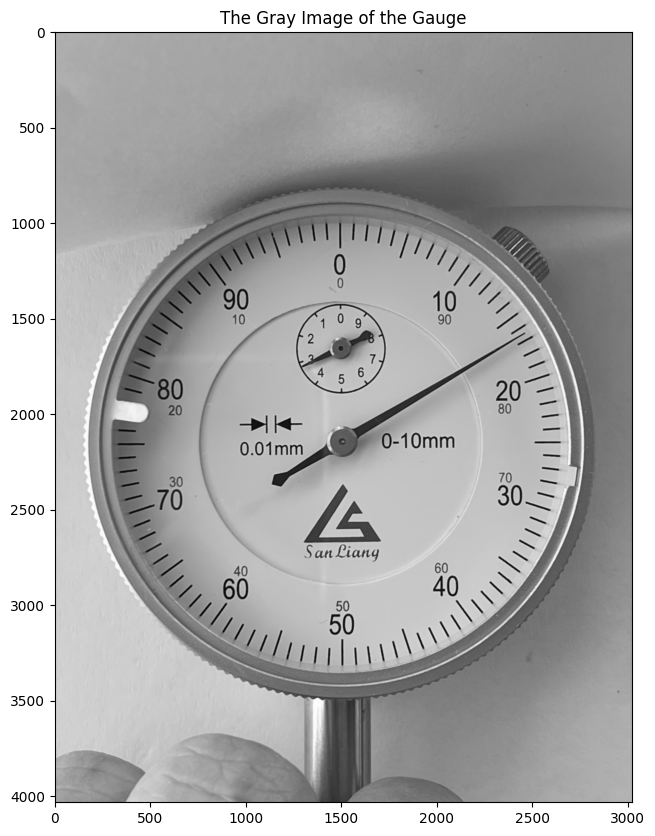

In [8]:
image = cv2.imread(IMAGE_PATH)
originalHeight, originalWidth = image.shape[0:2]
grayImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
grayImage = cv2.GaussianBlur(grayImage, (7,7), 1.5, 1.5)

print(f"The size of the image: Height: [{originalHeight}] px, Width: [{originalWidth}] px")
show_image_notebook(grayImage, scale=1/400, title='The Gray Image of the Gauge')

## Detect the circle of the dial

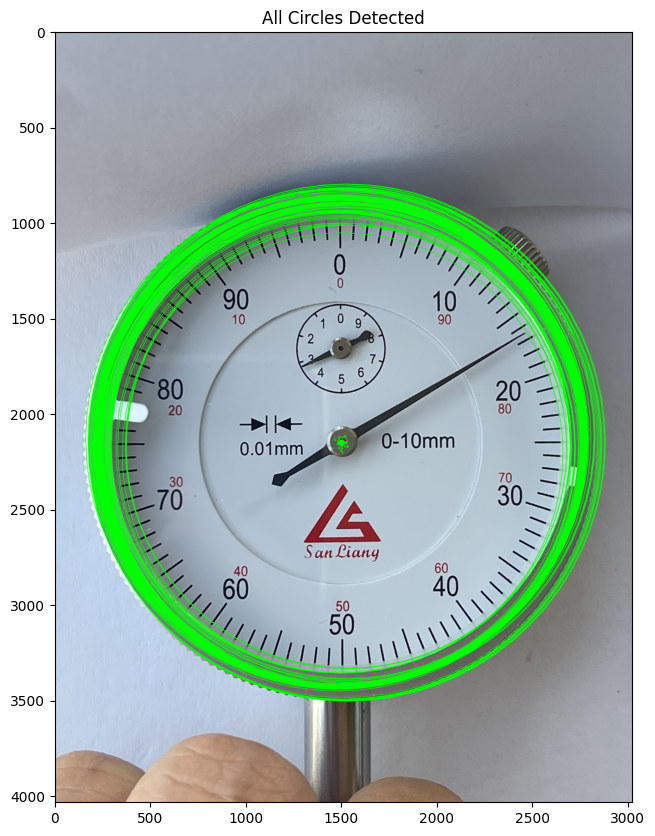

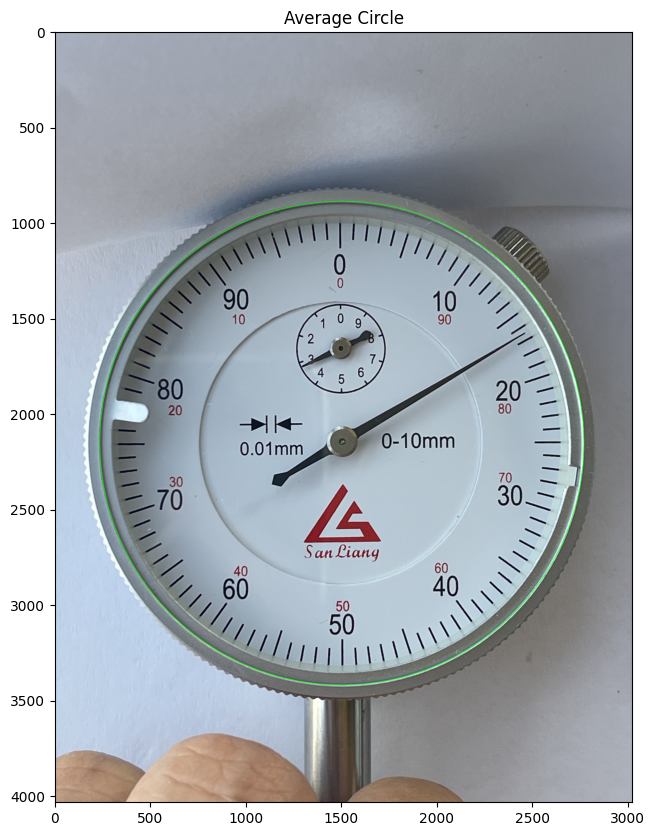

In [9]:
minDistance = round(1)
minR = round(originalWidth/3)
maxR = round(originalWidth/2)
circles = detect_circles(grayImage, originalWidth, originalHeight, minDistance, minR, maxR)

allDetectCircleResult = draw_circles(image, circles)
show_image_notebook(allDetectCircleResult, scale=1/400, title='All Circles Detected')

averageCircle = get_average_circle(circles)
detectCircleResult = draw_circles(image, np.array([averageCircle]))
show_image_notebook(detectCircleResult, scale=1/400, title='Average Circle')


## Crop the image

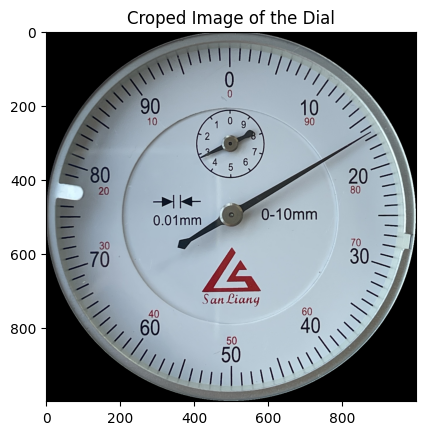

In [10]:
centerX, centerY, radius = averageCircle

mask = np.zeros_like(image)
mask = cv2.circle(mask, (centerX,centerY), radius, WHITE, -1)
mask = cv2.bitwise_not(mask)

maskedImage = cv2.subtract(image, mask)

padding = 0
upperLeft = (centerX-(radius+padding), centerY-(radius+padding))
lowerRight = (centerX+(radius+padding), centerY+(radius+padding))

dialImage = maskedImage[upperLeft[1] : (lowerRight[1]+1), upperLeft[0] : (lowerRight[0]+1)]
dialImage = cv2.resize(dialImage, (1000, 1000))
dialGrayImage = cv2.cvtColor(dialImage, cv2.COLOR_BGR2GRAY)

show_image_notebook(dialImage, scale=1, title='Croped Image of the Dial')

## Detect the line of the needle

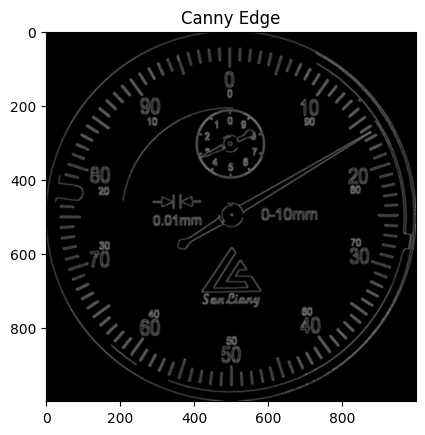

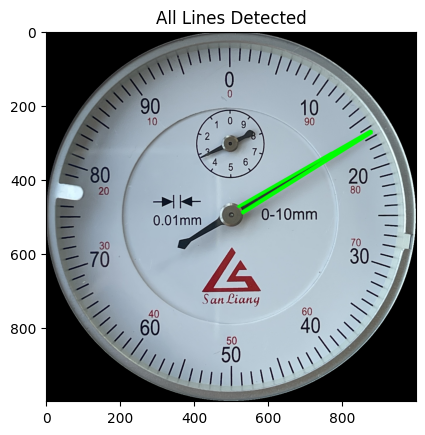

In [11]:
dialHeight, dialWidth = dialGrayImage.shape
center = np.around(np.array([dialWidth, dialHeight]) / 2).astype(int)

minLength = dialWidth*0.17
maxGap = 5
lines = detect_lines(dialGrayImage, minLength, maxGap, cannyParam1=200, cannyParam2=400)

threshold = 100
validLines = filter_lines(lines, threshold, center)
detectLineResult = draw_lines(dialImage, validLines)

show_image_notebook(detectLineResult, scale=1, title='All Lines Detected')

## Find the furthest point

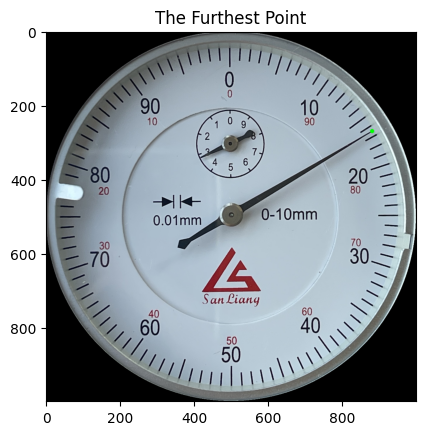

In [12]:
furthestPoint = find_furthest_point(validLines, center)
furthestPointResult = draw_point(dialImage, furthestPoint)

show_image_notebook(furthestPointResult, scale=1, title='The Furthest Point')

## Calculate the angle

The pointer is at [58.881688753551884] degree


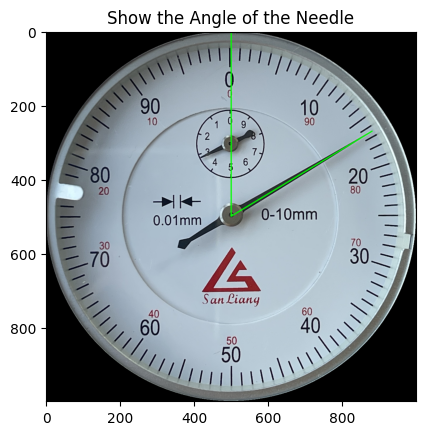

In [13]:
angleDegree = calculate_pointer_angle(center, furthestPoint)
print(f"The pointer is at [{angleDegree}] degree")

zeroLine = np.array([center, [center[0], 0]])
needleLine = np.array([center, furthestPoint])

angleResult = draw_lines(dialImage, np.array([zeroLine, needleLine]))
show_image_notebook(angleResult, scale=1, title='Show the Angle of the Needle')

## Read the dial

The reading of the gauge is [16.36].


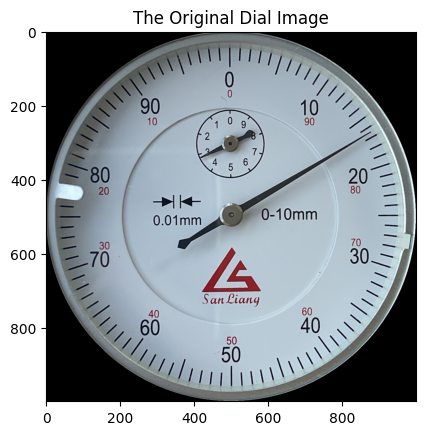

In [14]:
maxReading = 100
bigDialReading = read_dial(angleDegree, maxReading)

print(f"The reading of the gauge is [{bigDialReading}].")
show_image_notebook(dialImage, scale=1, title='The Original Dial Image')

# Combine each step into a big function

In [15]:
def read_dial_indicator(imagePath, imageOutPath, circleMinDistance, circleMinRDivWidth, circleMaxRDivWidth, lineMinLengthDivWidth, lineMaxGap, lineDistanceThreshold, lineCannyParam1, lineCannyParam2, maxReading, clockwise=True, displayScale=1, debug=False):
    # ==================================================
    # Load image and preprocess the image
    # ==================================================
    image = cv2.imread(imagePath)
    originalHeight, originalWidth = image.shape[0:2]
    grayImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    grayImage = cv2.GaussianBlur(grayImage, (7,7), 1.5, 1.5)

    print(f"Loaded image: [{imagePath}]")
    if debug:
        print(f"The size of the image: Height: [{originalHeight}] px, Width: [{originalWidth}] px")
        show_image_notebook(grayImage, scale=displayScale, title='The Gray Image of the Gauge')


    # ==================================================
    # Detect the circle
    # ==================================================
    minDistance = round(circleMinDistance)
    minR = round(originalWidth*circleMinRDivWidth)
    maxR = round(originalWidth*circleMaxRDivWidth)
    circles = detect_circles(grayImage, originalWidth, originalHeight, minDistance, minR, maxR)
    averageCircle = get_average_circle(circles)

    if debug:
        allDetectCircleResult = draw_circles(image, circles)
        show_image_notebook(allDetectCircleResult, scale=displayScale, title='All Circles Detected')

        detectCircleResult = draw_circles(image, np.array([averageCircle]))
        show_image_notebook(detectCircleResult, scale=displayScale, title='Average Circle')


    # ==================================================
    # Crop the image
    # ==================================================
    centerX, centerY, radius = averageCircle

    mask = np.zeros_like(image)
    mask = cv2.circle(mask, (centerX,centerY), radius, WHITE, -1)
    mask = cv2.bitwise_not(mask)
    maskedImage = cv2.subtract(image, mask)

    padding = 0
    upperLeft = (centerX-(radius+padding), centerY-(radius+padding))
    lowerRight = (centerX+(radius+padding), centerY+(radius+padding))

    dialImage = maskedImage[upperLeft[1] : (lowerRight[1]+1), upperLeft[0] : (lowerRight[0]+1)]
    dialImage = cv2.resize(dialImage, (1000, 1000))
    dialGrayImage = cv2.cvtColor(dialImage, cv2.COLOR_BGR2GRAY)
    cv2.imwrite(imageOutPath, dialImage)
    
    if debug:
        show_image_notebook(dialImage, title='Croped Image of the Dial')


    # ==================================================
    # Detect lines of the needle
    # ==================================================
    dialHeight, dialWidth = dialGrayImage.shape
    center = np.around(np.array([dialWidth, dialHeight]) / 2).astype(int)

    minLength = round(dialWidth*lineMinLengthDivWidth)
    maxGap = round(lineMaxGap)
    lines = detect_lines(dialGrayImage, minLength, maxGap, cannyParam1=lineCannyParam1, cannyParam2=lineCannyParam2)
    validLines = filter_lines(lines, lineDistanceThreshold, center)

    if debug:
        detectLineResult = draw_lines(dialImage, validLines)
        show_image_notebook(detectLineResult, title='All Lines Detected')


    # ==================================================
    # Find the furthest point
    # ==================================================
    furthestPoint = find_furthest_point(validLines, center)
    furthestPointResult = draw_point(dialImage, furthestPoint)

    if debug:
        show_image_notebook(furthestPointResult, title='The Furthest Point')


    # ==================================================
    # Calculate the angle
    # ==================================================
    angleDegree = calculate_pointer_angle(center, furthestPoint)
    print(f"The pointer is at [{angleDegree}] degree")

    zeroLine = np.array([center, [center[0], 0]])
    needleLine = np.array([center, furthestPoint])

    angleResult = draw_lines(dialImage, np.array([zeroLine, needleLine]))
    show_image_notebook(angleResult, title='Show the Angle of the Needle')


    # ==================================================
    # Read the dial
    # ==================================================
    dialReading = read_dial(angleDegree, maxReading, clockwise)

    print(f"The reading of the gauge is [{dialReading}].")
    show_image_notebook(dialImage, title='The Original Dial Image')

    return dialReading

# Read the big dial

Loaded image: [Images/Dial_Indicator_1.jpg]


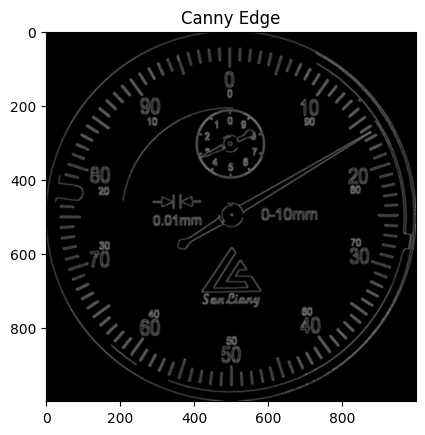

The pointer is at [58.881688753551884] degree


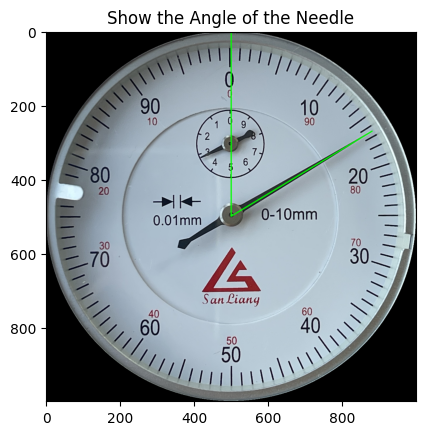

The reading of the gauge is [16.36].


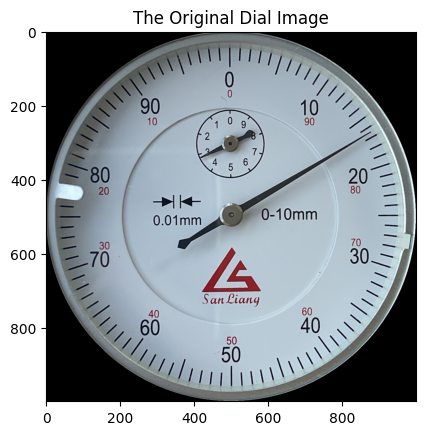

In [16]:
dialReading = read_dial_indicator(IMAGE_PATH, IMAGE_OUT_PATH, circleMinDistance=1, circleMinRDivWidth=1/3, circleMaxRDivWidth=0.5, lineMinLengthDivWidth=0.17, lineMaxGap=5, lineDistanceThreshold=100, lineCannyParam1=200, lineCannyParam2=400, maxReading=100, clockwise=True, displayScale=1/400, debug=False)

# Read the revolution counter

Loaded image: [Images/Dial_Indicator_1_dial_only.jpg]


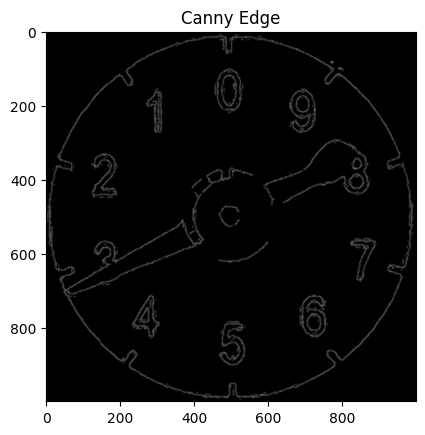

The pointer is at [245.68871797504457] degree


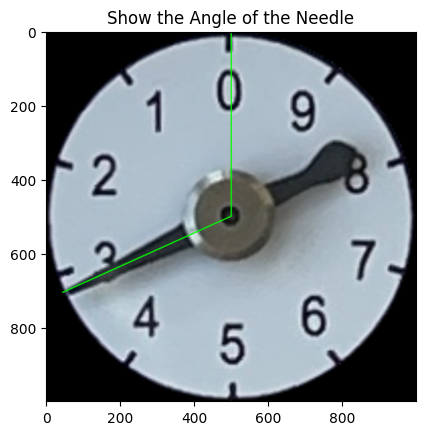

The reading of the gauge is [3.18].


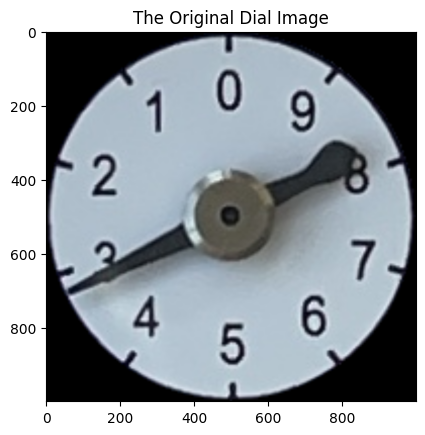

In [17]:
revolutionCounter = read_dial_indicator(DIAL_ONLY_IMAGE_PATH, DIAL_ONLY_IMAGE_OUT_PATH, circleMinDistance=1, circleMinRDivWidth=0.01, circleMaxRDivWidth=0.25, lineMinLengthDivWidth=0.15, lineMaxGap=10, lineDistanceThreshold=100, lineCannyParam1=40, lineCannyParam2=80, maxReading=10, clockwise=False, displayScale=1, debug=False)

revolutionCounter = np.floor(revolutionCounter)

# Calculate final result

The final reading of the dial is [316.36].


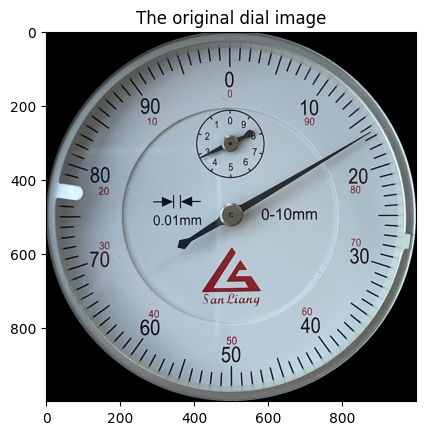

In [18]:
finalResult = revolutionCounter * 100 + dialReading
print(f"The final reading of the dial is [{finalResult}].")

dialOnlyImage = cv2.imread(DIAL_ONLY_IMAGE_PATH)

show_image_notebook(dialOnlyImage, scale=1, title='The original dial image')

# Testing

Loaded image: [Images/Dial_Indicator_1.jpg]


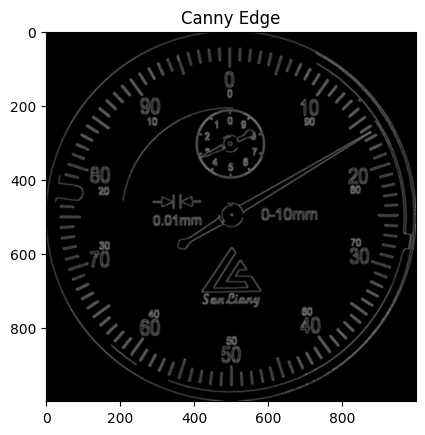

The pointer is at [58.881688753551884] degree


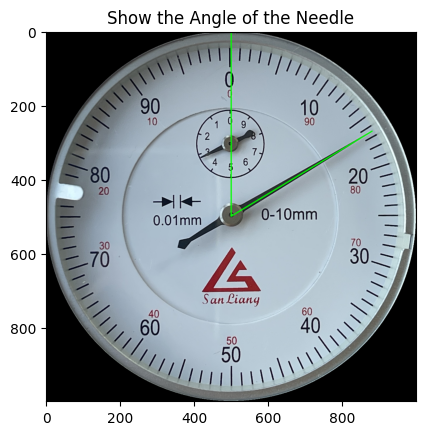

The reading of the gauge is [16.36].


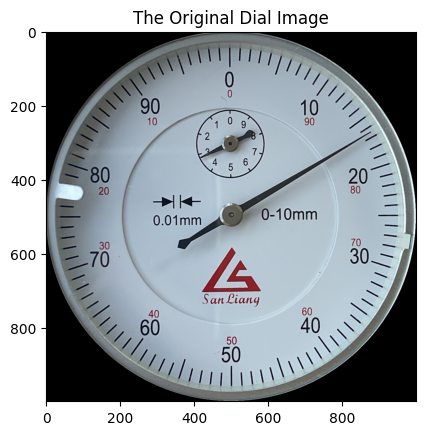

Loaded image: [Images/Dial_Indicator_1_dial_only.jpg]


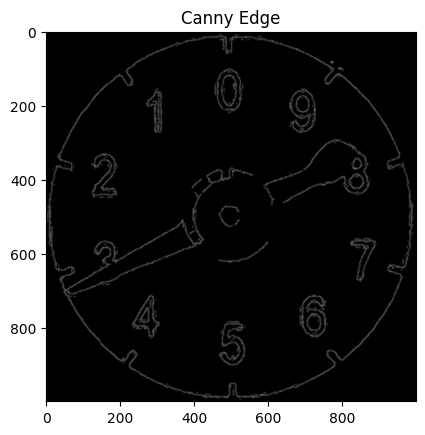

The pointer is at [245.68871797504457] degree


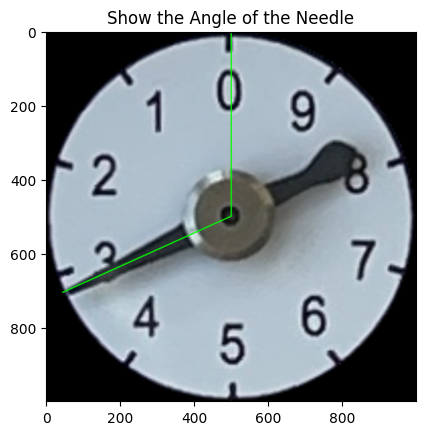

The reading of the gauge is [3.18].


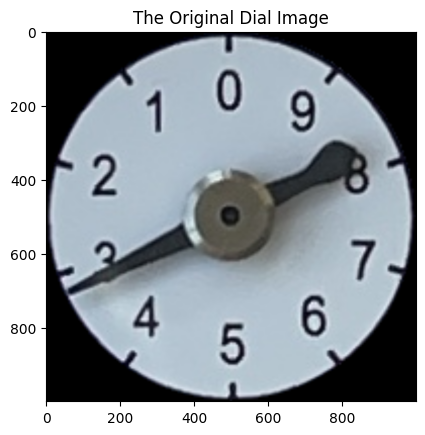

The final reading of the dial is [316.36].


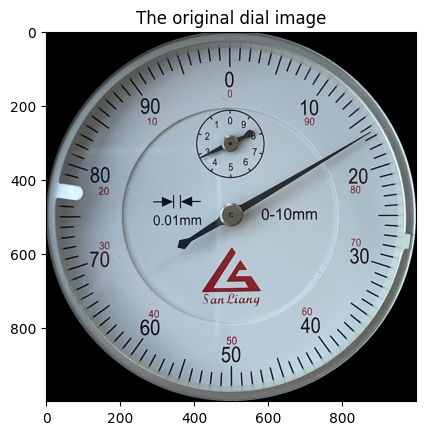

Loaded image: [Images/Dial_Indicator_2.jpg]


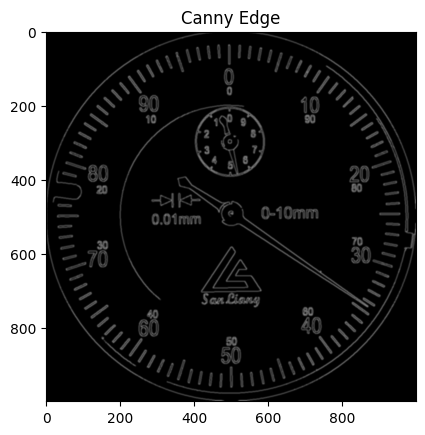

The pointer is at [122.7125378706352] degree


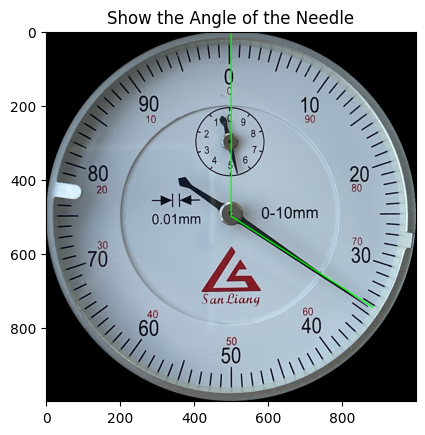

The reading of the gauge is [34.09].


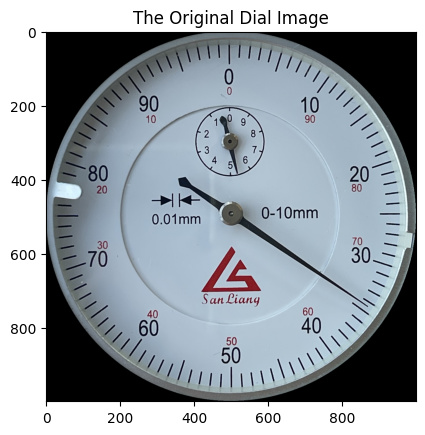

Loaded image: [Images/Dial_Indicator_2_dial_only.jpg]


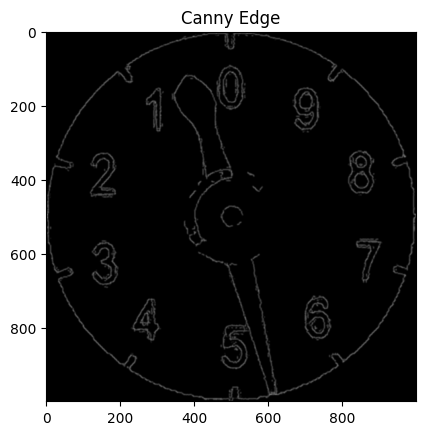

The pointer is at [165.32623909388516] degree


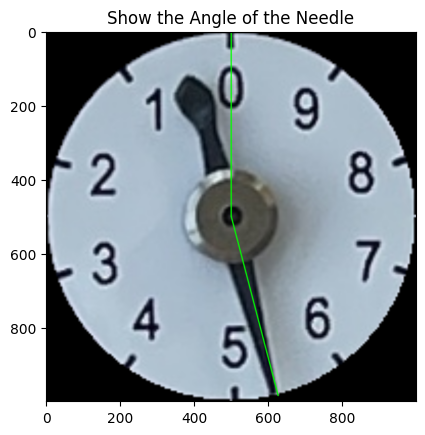

The reading of the gauge is [5.41].


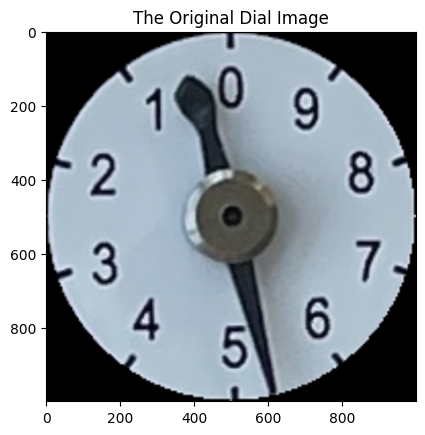

The final reading of the dial is [534.09].


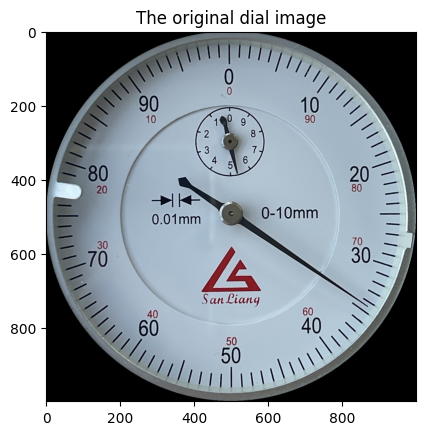

Loaded image: [Images/Dial_Indicator_3.jpg]


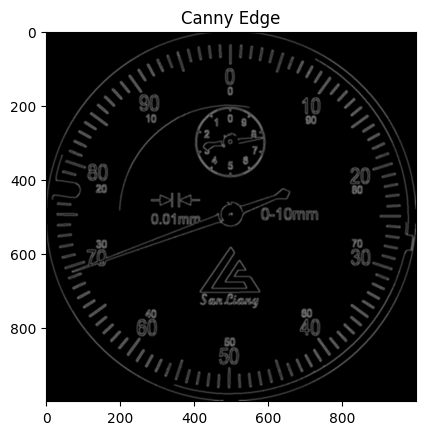

The pointer is at [250.53920332485967] degree


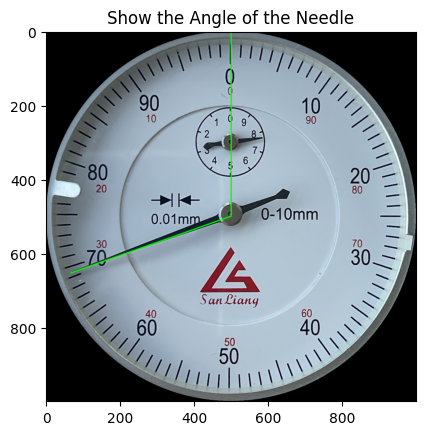

The reading of the gauge is [69.59].


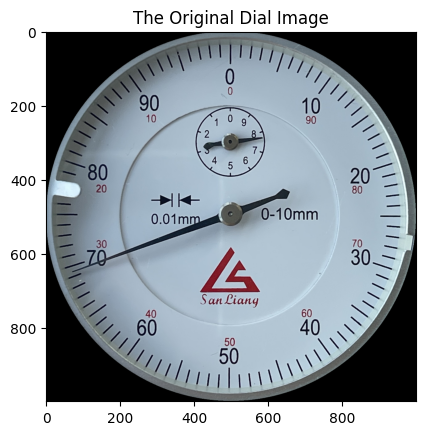

Loaded image: [Images/Dial_Indicator_3_dial_only.jpg]


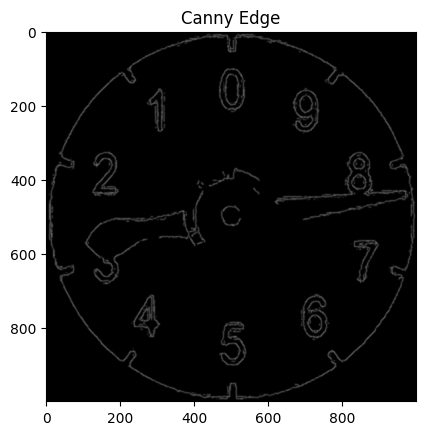

The pointer is at [83.74911356065813] degree


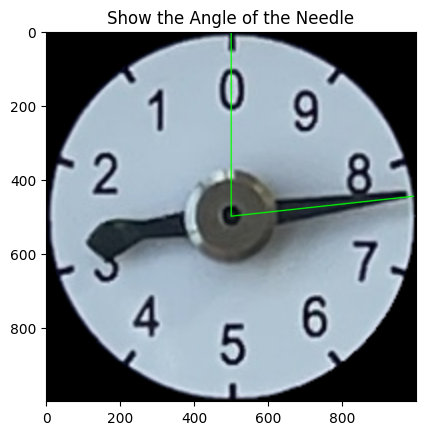

The reading of the gauge is [7.67].


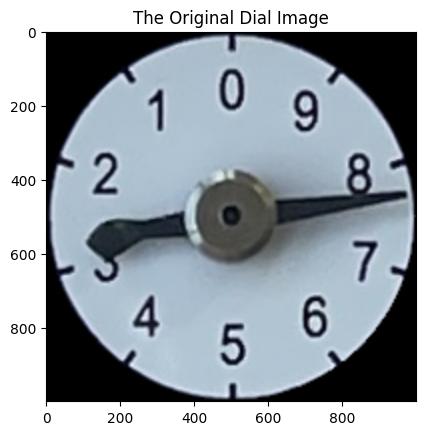

The final reading of the dial is [769.59].


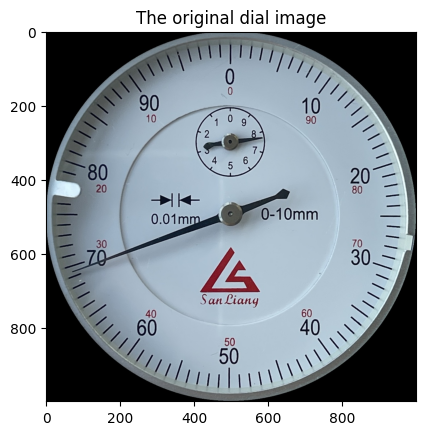

Loaded image: [Images/Dial_Indicator_4.jpg]


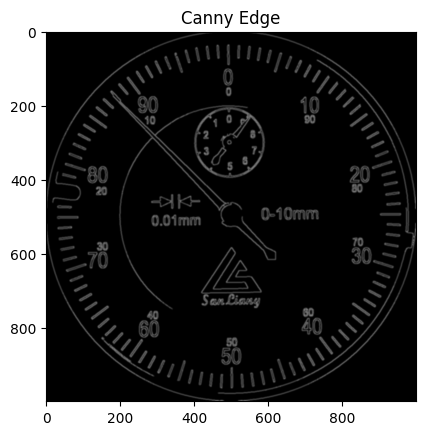

The pointer is at [316.200633981525] degree


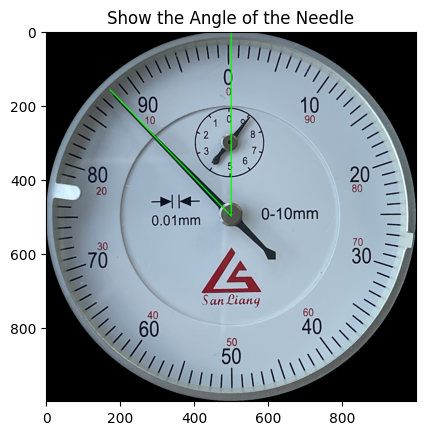

The reading of the gauge is [87.83].


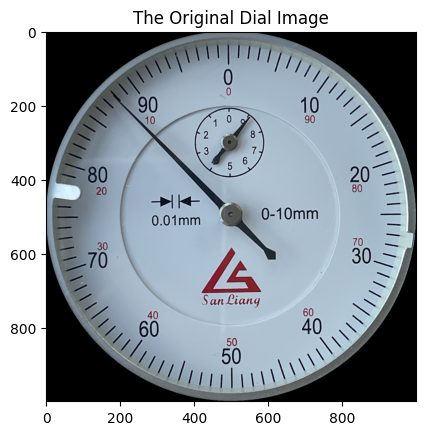

Loaded image: [Images/Dial_Indicator_4_dial_only.jpg]


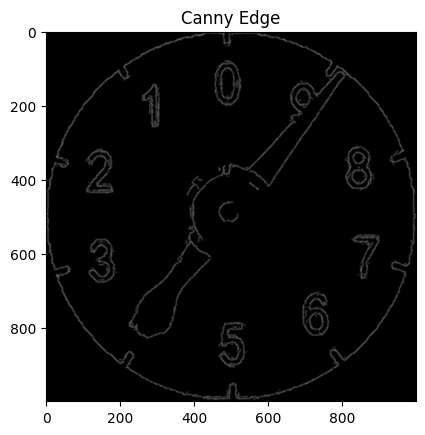

The pointer is at [38.76686969195176] degree


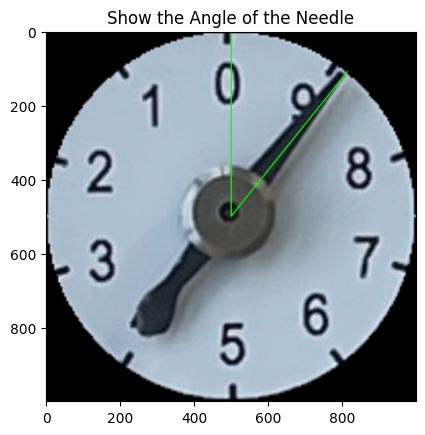

The reading of the gauge is [8.92].


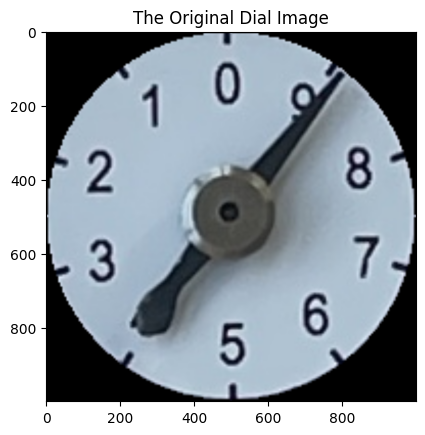

The final reading of the dial is [887.83].


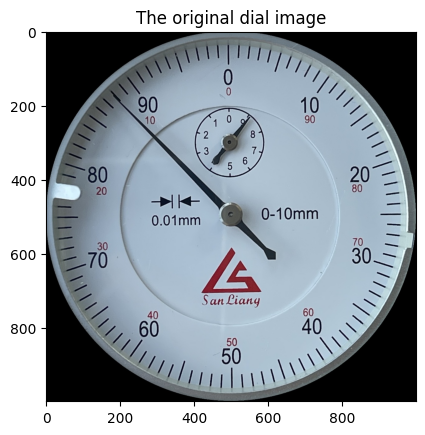

In [20]:
for i in range(1, 5):
    IMAGE_PATH = f"Images/Dial_Indicator_{i}.jpg"
    IMAGE_OUT_PATH = f"Images/Dial_Indicator_{i}_dial_only.jpg"
    DIAL_ONLY_IMAGE_PATH = f"Images/Dial_Indicator_{i}_dial_only.jpg"
    DIAL_ONLY_IMAGE_OUT_PATH = f"Images/Dial_Indicator_{i}_revoluton_counter.jpg"

    dialReading = read_dial_indicator(IMAGE_PATH, IMAGE_OUT_PATH, circleMinDistance=1, circleMinRDivWidth=1/3, circleMaxRDivWidth=0.5, lineMinLengthDivWidth=0.17, lineMaxGap=5, lineDistanceThreshold=100, lineCannyParam1=200, lineCannyParam2=400, maxReading=100, clockwise=True, displayScale=1/400)

    revolutionCounter = read_dial_indicator(DIAL_ONLY_IMAGE_PATH, DIAL_ONLY_IMAGE_OUT_PATH, circleMinDistance=1, circleMinRDivWidth=0.01, circleMaxRDivWidth=0.25, lineMinLengthDivWidth=0.15, lineMaxGap=10, lineDistanceThreshold=100, lineCannyParam1=40, lineCannyParam2=80, maxReading=10, clockwise=False, displayScale=1)

    revolutionCounter = np.floor(revolutionCounter)

    finalResult = revolutionCounter * 100 + dialReading
    print(f"The final reading of the dial is [{finalResult}].")

    dialOnlyImage = cv2.imread(DIAL_ONLY_IMAGE_PATH)
    show_image_notebook(dialOnlyImage, scale=1, title='The original dial image')